In [2]:
import numpy as np
from sklearn import metrics
from sklearn import datasets
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs


podatci sintetički MAKE MOONS

In [3]:
X, y = datasets.make_moons(n_samples=200, noise=0.05, random_state=42)
# broj točaka
n = X.shape[0]  

## 1. affinity/similarity matrix


In [4]:
# init. adjacency marticu 
A = np.zeros((n, n)) 

# moram napraviti matricu s euclidian udaljenostima
dists = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n): 
        dist = np.sqrt(np.sum((X[i] - X[j]) ** 2)) 
        dists[i, j] = dist
        dists[j, i] = dist 
k=10
        
## kk-nn metoda       
for i in range(n):
    neighbors = np.argsort(dists[i])[1:k+1] 
    for j in neighbors:
        A[i][j] = np.exp(-dists[i][j]**2 / 0.1) 
        A[j][i] = A[i][j]
# pripaziti da su na dijagonali 0
np.fill_diagonal(A, 0)



# RBF metoda
""" for i in range(n):
    neighbors = np.argsort(dists[i])[1:k+1] 
    for j in range(n):
        # RBF similarity function
        ##A[i,j] = np.exp(-np.sum((X[i] - X[j])**2) / (2 * sigma**2))
        # RBF krenel with euclidian distance
        dist_ij = np.sqrt(np.sum((X[i] - X[j]) ** 2)) 
        A[i,j] = np.exp(-1.0 * dist_ij ** 2)  """


""" - more controlled decay
    - exponential decay: udaljenije točke imaju jako nisu razinu sličnosti
    - sigma utječe na brzinu smanjenja sličnosti kako se euk.dist povećava
        - malena sigma: sličnost pada brzo kako se distanca povećava
        - velik sigma: sličnost se smanjuje sporo - udaljenije točke i dalje
          imaju veliku sličnost"""

' - more controlled decay\n    - exponential decay: udaljenije točke imaju jako nisu razinu sličnosti\n    - sigma utječe na brzinu smanjenja sličnosti kako se euk.dist povećava\n        - malena sigma: sličnost pada brzo kako se distanca povećava\n        - velik sigma: sličnost se smanjuje sporo - udaljenije točke i dalje\n          imaju veliku sličnost'

## 2. degree matrix

In [5]:
# trebamo matricu koja je suma redaka od ajd
D = np.zeros((n, n))  
for i in range(n):
    D[i, i] = np.sum(A[i]) 


3. un-normalized laplacian

In [6]:
L = D - A
""" dijagonalni elementi matrice su stupnjevi čvorova, a ne-dijagonalni elementi 
"""
# https://freedium.cfd/https://medium.com/@roiyeho/spectral-clustering-50aee862d300


# normalized laplacian
""" D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))  # D^(-1/2)
L = D_inv_sqrt @ L @ D_inv_sqrt """

' D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))  # D^(-1/2)\nL = D_inv_sqrt @ L @ D_inv_sqrt '

4. eigenvalues/ eigenvectors

In [7]:
# preko built in funkcije
eigvals, eigvecs = np.linalg.eig(L)
#print("Eigenvalues:", eigvals)
#print("Eigenvectors:", eigvecs)

# det(L -I*lambda) = 0  karakteristični polinomial čija su rješenja lambda1, lambda2...
# riješiti (L - lambda*I) v = 0 za svaku lambdu/eigenvrijednost

# uzimam drugi najmanji fiedlerov vektor na temelju kojeg dijelim
fiedler_vector = eigvecs[:, 1]

5. visualization

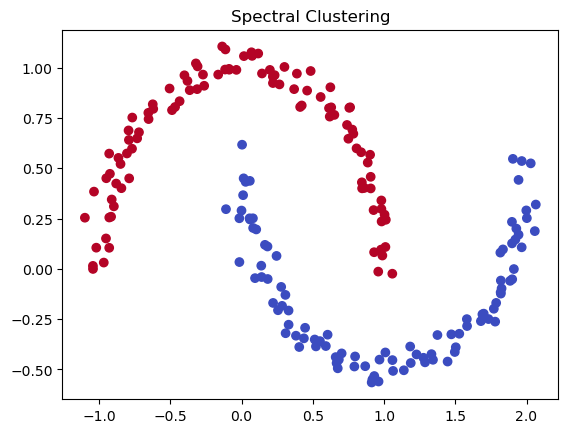

In [8]:
# dijelim podatke u ovisnosti o pozitivnosti/negativnosti
clusters = np.where(fiedler_vector >= 0, 1, 0)

# vizualizacija
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap="coolwarm")
plt.title("Spectral Clustering")
plt.show()

primjer za usporedbu sa built-in metodom SpectralClustering

c:\Users\mestr\miniconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


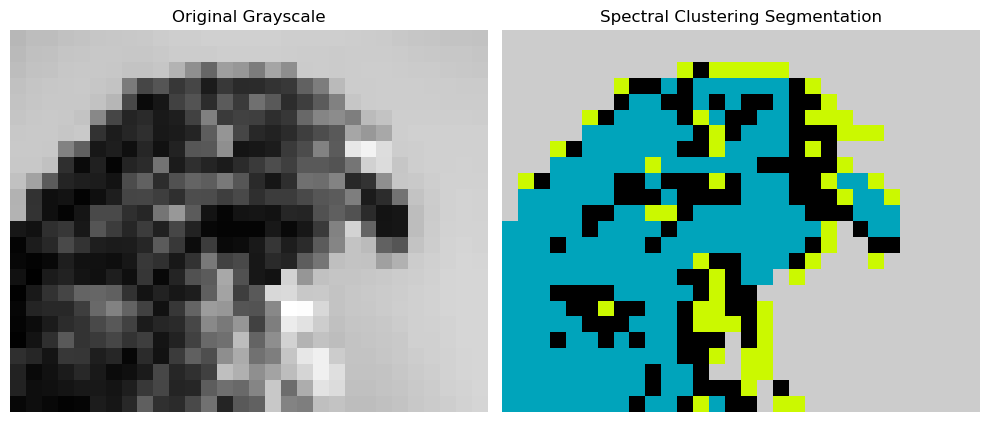

In [ ]:
import numpy as np
from skimage import io, color
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt
import time

def load_grayscale_image(path):
    img = io.imread(path, as_gray=True).astype(np.float64)
    if img.ndim == 3:
        img = color.rgb2gray(img)
    img = (img * 255).astype(np.uint8)  # Scale to 0–255
    img = img[:64, :64] 
    return img

def create_affinity_matrix(img, gamma_s=0.001, gamma_i=0.01):

    h, w = img.shape
    coords = np.indices((h, w)).reshape(2, -1).T
    intensities = img.flatten().reshape(-1, 1)

    spatial_sim = rbf_kernel(coords, coords, gamma=gamma_s)
    intensity_sim = rbf_kernel(intensities, intensities, gamma=gamma_i)

    affinity = spatial_sim * intensity_sim

    return affinity


def spectral_segment(img, n_clusters=8):
    affinity = create_affinity_matrix(img)
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans')
    labels = clustering.fit_predict(affinity)
    return labels.reshape(img.shape)


img_path = 'eagle_30px.png'  
img = load_grayscale_image(img_path)
segmented = spectral_segment(img, n_clusters=4)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Grayscale")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Spectral Clustering Segmentation")
plt.imshow(segmented, cmap='nipy_spectral')
plt.axis('off')
plt.tight_layout()
plt.show() ; 